## Mounting drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Loading data

In [2]:
import glob
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

folder_npy = '/content/drive/My Drive/covidctnet-master/preprocessed/ct-normal-slices-test'

file_paths = glob.glob(os.path.join(folder_npy, '*.npy'))
file_paths.sort()
print(file_paths)
print(len(file_paths))

['/content/drive/My Drive/covidctnet-master/preprocessed/ct-normal-slices-test/F_0005_300_349_349_C_1674971.rar (Unzipped Files.npy', '/content/drive/My Drive/covidctnet-master/preprocessed/ct-normal-slices-test/F_0006_350_402_402_C_1674972.rar (Unzipped Files.npy', '/content/drive/My Drive/covidctnet-master/preprocessed/ct-normal-slices-test/F_0007_300_322_322_C_1674976.rar (Unzipped Files.npy', '/content/drive/My Drive/covidctnet-master/preprocessed/ct-normal-slices-test/F_0021_350_389_389_N_142630.zip (Unzipped Files.npy', '/content/drive/My Drive/covidctnet-master/preprocessed/ct-normal-slices-test/F_0022_295_334_334_N_1461042.zip (Unzipped Files.npy', '/content/drive/My Drive/covidctnet-master/preprocessed/ct-normal-slices-test/F_0023_365_365_365_N_1471242.zip (Unzipped Files.npy', '/content/drive/My Drive/covidctnet-master/preprocessed/ct-normal-slices-test/F_0034_339_340_340_P_1527625.rar (Unzipped Files.npy', '/content/drive/My Drive/covidctnet-master/preprocessed/ct-normal-sli

## BCDU-net

In [3]:
from __future__ import division
from keras.models import Model
from keras.layers import Input
from keras.layers import concatenate
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import UpSampling2D
from keras.layers import Reshape
from keras.layers import core
from keras.layers import Dropout
from keras.layers import Conv2DTranspose
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import ConvLSTM2D
from keras.optimizers import Adam
    
def BCDU_net_D3(input_size = (128,128,1)):
    N = input_size[0]
    inputs = Input(input_size) 
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # D1
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)     
    conv4_1 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4_1 = Dropout(0.5)(conv4_1)
    # D2
    conv4_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4_1)     
    conv4_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_2)
    conv4_2 = Dropout(0.5)(conv4_2)
    # D3
    merge_dense = concatenate([conv4_2,drop4_1], axis = 3)
    conv4_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge_dense)     
    conv4_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_3)
    drop4_3 = Dropout(0.5)(conv4_3)
    
    up6 = Conv2DTranspose(128, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(drop4_3)
    up6 = BatchNormalization(axis=3)(up6)
    up6 = Activation('relu')(up6)

    x1 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 128))(drop3)
    x2 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 128))(up6)
    merge6  = concatenate([x1,x2], axis = 1) 
    merge6 = ConvLSTM2D(filters = 64, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal')(merge6)
            
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2DTranspose(64, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv6)
    up7 = BatchNormalization(axis=3)(up7)
    up7 = Activation('relu')(up7)

    x1 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 64))(conv2)
    x2 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 64))(up7)
    merge7  = concatenate([x1,x2], axis = 1) 
    merge7 = ConvLSTM2D(filters = 32, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge7)
        
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2DTranspose(32, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv7)
    up8 = BatchNormalization(axis=3)(up8)
    up8 = Activation('relu')(up8)    

    x1 = Reshape(target_shape=(1, N, N, 32))(conv1)
    x2 = Reshape(target_shape=(1, N, N, 32))(up8)
    merge8  = concatenate([x1,x2], axis = 1) 
    merge8 = ConvLSTM2D(filters = 16, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge8)    
    
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv9 = Conv2D(1, 1, activation = 'sigmoid')(conv8)

    model = Model(inputs, conv9)
    return model

In [4]:
model = BCDU_net_D3(input_size = (128,128,1))
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [5]:
model.load_weights('/content/drive/My Drive/covidctnet-master/Model_weight/weight_BCDUNET.hdf5')

### Resizing the slices for BCDUNET model

In [6]:
from skimage.transform import resize

In [7]:
from scipy import signal
from tqdm import tqdm
dataset = np.zeros((len(file_paths),50,128,128))
counter = 0
for j in tqdm(file_paths):
    # print(j)
    CT = np.load(j)
    CT_resized = resize(CT, (CT.shape[0],128, 128),anti_aliasing=True)
    out = model.predict(np.reshape(CT_resized,(CT_resized.shape[0],CT_resized.shape[1],CT_resized.shape[2],1)))
    c = CT_resized-out[:,:,:,0]
    dataset[counter] = resize(c,(50,128,128))
    counter +=1

100%|██████████| 9/9 [00:53<00:00,  5.96s/it]


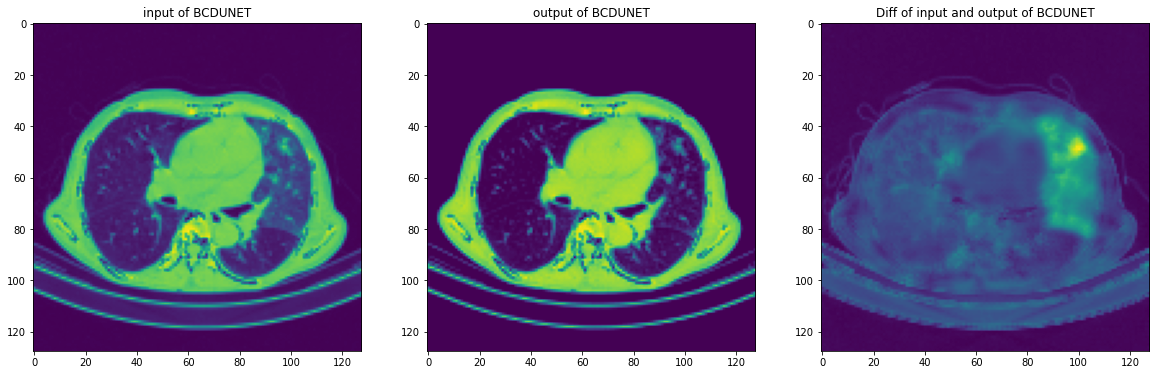

In [8]:
import matplotlib.pyplot as plt

j = file_paths[6]
CT = np.load(j)
CT_resized = resize(CT, (CT.shape[0],128, 128),anti_aliasing=True)
out = model.predict(np.reshape(CT_resized,(CT_resized.shape[0],CT_resized.shape[1],CT_resized.shape[2],1)))
c = CT_resized-out[:,:,:,0]
diff = resize(c,(50,128,128))

plt.figure(figsize=(20,12))

plt.subplot(131)
plt.title('input of BCDUNET')
plt.imshow(CT_resized[int(CT_resized.shape[0]/2),:,:])

plt.subplot(132)
plt.title('output of BCDUNET')
plt.imshow(out[int(out.shape[0]/2),:,:,0])

plt.subplot(133)
plt.title('Diff of input and output of BCDUNET')
plt.imshow(diff[25,:,:])

In [9]:
dataset = np.reshape(dataset,(dataset.shape[0],dataset.shape[1],dataset.shape[2],dataset.shape[3],1))

## 3D CNN model

In [10]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D,Dropout
from keras.utils import to_categorical
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [11]:
model = Sequential()
model.add(Conv3D(8, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(50,128,128,1)))
model.add(Conv3D(8, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 48, 126, 126, 8)   224       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 48, 126, 126, 8)   1736      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 24, 63, 63, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 24, 63, 63, 16)    3472      
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 24, 63, 63, 16)    6928      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 12, 31, 31, 16)    0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 12, 31, 31, 32)    1

### Loading 3D CNN

In [12]:
from keras.models import model_from_json

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights("/content/drive/My Drive/covidctnet-master/Model_weight/weight_cnn_CovidCtNet.h5")

### Final Prediction

In [13]:
test2 = np.array([1, 1, 1, 
                  0, 0, 0,
                  2 ,2 ,2 ])

In [14]:
predicted = loaded_model.predict(dataset)

Label = ['Control','COVID-19','CAP']
for i in range(predicted.shape[0]):
    lbl = np.argmax(predicted[i])
    print('The case number %d is'%i, test2[i],'and predicted',lbl, 'with probibility of %.2f'%(100*predicted[i,lbl]))

The case number 0 is 1 and predicted 1 with probibility of 100.00
The case number 1 is 1 and predicted 1 with probibility of 99.66
The case number 2 is 1 and predicted 1 with probibility of 99.65
The case number 3 is 0 and predicted 0 with probibility of 74.47
The case number 4 is 0 and predicted 0 with probibility of 97.43
The case number 5 is 0 and predicted 0 with probibility of 94.74
The case number 6 is 2 and predicted 2 with probibility of 95.24
The case number 7 is 2 and predicted 2 with probibility of 98.69
The case number 8 is 2 and predicted 2 with probibility of 95.83
